# Analysis de los experimentos de Broadcasting

Autor: Jorge Daniel Laborda

## Introducción
---


En este notebook se analizan los resultados de los experimentos de broadcasting. Hemos experimentado con dos tipos de Broadcasting:
* ALL_BROADCASTING: Al final de cada iteración cogemos todos los BNs generados por los procesos del cges y los fusionamos usando un ConsensusUnion. La red de consenso ahora se pasa a cada proceso de la siguiente iteración de forma que si el proceso obtiene un resultado peor en bdeu a la red de consenso, se sustituye por la red de consenso. El pseudocódigo de este algoritmo sería algo así:
   ```
   Inicio del Algoritmo CGES con All_Broadcasting:
   
   1. Realizar particiones y procesos circulares del algoritmo.
   
   2. Para cada iteración:
      a. Realizar el proceso de CGES en paralelo para generar BNs individuales.
      b. Al final de la iteración:
         - Fusionar todos los BNs generados utilizando ConsensusUnion.
         - Almacenar la red de consenso resultante.
   
      c. Para cada proceso en la siguiente iteración:
         i. Proporcionar la red de consenso como entrada al proceso además de la red del proceso previo.
         ii. Ejecutar el proceso CGES individualmente con la nueva entrada.
         iii. Comparar el resultado en términos de BDeu con la red de consenso.
         iv. Si el resultado del proceso es peor, reemplazar la red del proceso con la red de consenso.
   
   3. Repetir el ciclo hasta que se cumpla el criterio de convergencia.
   
   Fin del Algoritmo CGES con All_Broadcasting.
   ```

----------------------------------------------------------

* PAIR_BORADCASTING: Este cambio es un poco distinto al previo ya que toca directamente la fusión de cada proceso. En este caso, todas las redes generadas en cada iteración se comparten con las demás redes, para la siguiente iteración. Por lo tanto, en la fase de fusión del proceso circular están disponibles todas las redes generadas por los demás procesos. Ahora, la red construida por el proceso se fusiona con las demás redes a pares. Por ejemplo, si tenemos 4 procesos (A,B,C y D). En el proceso A están disponibles las redes de B, C y D. Las fusiones realizadas serían A con B, A con C y A con D. Se calcularía la puntuación bdeu de cada red generada, y el proceso se quedaría con la red con la mejor bdeu. Para refinar el proceso, aplicamos un BES al final. Después el proceso circular continua aplicando a esta red nueva un GES con los enlaces a los que está limitado y se repite hasta que haya una convergencia. 
El pseudocódigo quedaría algo así:
   ```
   Inicio del Algoritmo CGES con Pair Broadcasting:
   
   1. Realizar particiones y procesos circulares del algoritmo.
   
   2. Para cada iteración:
      a. Realizar el proceso de CGES en paralelo para generar BNs individuales.
      b. Al final de la iteración:
         - Compartir todas las redes generadas con los demás procesos.
         - Para cada proceso:
            i. Fusionar la red construida por el proceso con las demás redes a pares.
            ii. Calcular la puntuación BDeu de cada red resultante.
            iii. Seleccionar la red con la mejor puntuación BDeu y actualizar la red del proceso.
   
      c. Aplicar un BES a la red seleccionada por cada proceso.

      d.  Aplicar un GES a la red resultante, limitado a los enlaces permitidos.

      e.  Actualizar la red del proceso con el resultado del GES.
   
   3. Repetir el ciclo hasta que se cumpla el criterio de convergencia.
   
   Fin del Algoritmo CGES con Pair Broadcasting.
```



### Descripción de los Experimentos realizados
Los experimentos han utilizado los siguientes parámetros: algName,netName,clusteringName,numberOfRealThreads,convergence,broadcasting. 
Los valores de los parámetros son los siguientes:
* algName: CGES
* netName: Nombre de la red a utilizar. En este caso, se han usado las redes andes, link, pigs y munin.
* clusteringName: Nombre del clustering a utilizar. En este caso solo se ha usado el HierarchicalClustering.
* numberOfRealThreads: Número de hilos a utilizar. El número de particiones de enlace se elige con este valor. En este caso, se han usado 1,2,4 y 8 hilos.
* convergence: Criterio de convergencia. En este caso, se ha usado el criterio `c2` que comprueba si algún BN de la iteración actual es mejor a la mejor BN obtenida hasta el momento.
* broadcasting: Tipo de broadcasting a utilizar. En este caso, se han usado los tipos `ALL_BROADCASTING` y `PAIR_BROADCASTING`.

Los experimentos se han lanzado sobre un nodo cluster2 del supercomputador galgo (`select=1:ncpus=16:mem=32gb:cluster=galgo2`).

A continuación realizaremos el análisis de los resultados obtenidos.

# Preprocesamiento

In [93]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Experimentos Fallidos o Incompletos

In [94]:
import pandas as pd
import itertools

def find_missing_experiments(df):
    # Define los valores posibles para cada parámetro
    netNames = df.netName.unique()
    databases = [f'{network}{i:02d}' for i in range(11) for network in netNames]
    broadcasting_types = ['ALL_BROADCASTING', 'PAIR_BROADCASTING', 'NO_BROADCASTING']
    thread_values = [1, 2, 4, 8]

    # Crea todas las combinaciones posibles de parámetros
    all_combinations = list(itertools.product(databases, broadcasting_types, thread_values))

    # Convierte las combinaciones en un DataFrame para buscarlas en el DataFrame original
    all_combinations_df = pd.DataFrame(all_combinations, columns=['database', 'broadcasting', 'threads'])

    # Busca las combinaciones en el DataFrame original
    missing_experiments = pd.merge(all_combinations_df, df, on=['database', 'broadcasting', 'threads'], how='left')

    # filas con un NaN en cualquier columna
    failed_experiments = df[df.isnull().any(axis=1)]

    # Filtra las filas donde faltan experimentos o hay errores (valores nulos)
    missing_or_failed_experiments = missing_experiments[missing_experiments.isnull().any(axis=1)]

    # Imprime los resultados
    if not missing_or_failed_experiments.empty or not failed_experiments.empty:
        print("Experimentos faltantes:")
        print(missing_or_failed_experiments[['database', 'broadcasting', 'threads']])
        print("Number of missing experiments:", len(missing_or_failed_experiments))
        print("-----------------------------------")
        print("Experimentos con errores:")
        print(failed_experiments[['database', 'broadcasting', 'threads']])
        print("Number of failed experiments:", len(failed_experiments))
    else:
        print("Todos los experimentos han sido ejecutados correctamente.")


# Read csv
df = pd.read_csv("results.csv")
# Dropping unnneccesary columns
df = df.drop(['algName','clusteringName', 'convergence'], axis=1)

# Rename columns
df = df.rename(columns={'elapsedTime(s)': 'time', 'numberOfRealThreads' : 'threads'})
find_missing_experiments(df)


Experimentos faltantes:
    database       broadcasting  threads
25   munin00   ALL_BROADCASTING        2
26   munin00   ALL_BROADCASTING        4
27   munin00   ALL_BROADCASTING        8
30   munin00  PAIR_BROADCASTING        4
31   munin00  PAIR_BROADCASTING        8
..       ...                ...      ...
507  munin10   ALL_BROADCASTING        8
510  munin10  PAIR_BROADCASTING        4
511  munin10  PAIR_BROADCASTING        8
514  munin10    NO_BROADCASTING        4
515  munin10    NO_BROADCASTING        8

[76 rows x 3 columns]
Number of missing experiments: 76
-----------------------------------
Experimentos con errores:
    database       broadcasting  threads
244   link05  PAIR_BROADCASTING        4
281   link08  PAIR_BROADCASTING        8
319  munin05   ALL_BROADCASTING        2
322  munin09   ALL_BROADCASTING        2
339  munin01   ALL_BROADCASTING        4
340  munin02   ALL_BROADCASTING        4
341  munin01    NO_BROADCASTING        4
342  munin02    NO_BROADCASTING      

In [95]:
# Read data from file 'results.csv'
df = pd.read_csv('./results.csv')

# array of strings of parameters: algName, netName, database, clusteringName, numberOfRealThreads, convergence, broadcasting
param_columns = ["algName", "netName", "database", "clusteringName", "numberOfRealThreads", "convergence", "broadcasting"]
#array of measurments:
measurement_columns = ["time", "shd", "dfMM_avg", "dfMM_plus", "dfMM_minus", "iterations", "bdeu"]

# Dropping unnneccesary columns
df = df.drop(['algName','clusteringName', 'convergence'], axis=1)

# Rename elapsedTime to time
df = df.rename(columns={'elapsedTime(s)': 'time', 'numberOfRealThreads' : 'threads'})

# Drop all rows with NaN values
df = df.dropna()

# Transform to numeric values all measurement columns
df[measurement_columns] = df[measurement_columns].apply(pd.to_numeric)


# Create a new df with the _all databases
df_all =df.copy()
df_all = df[df.database.str.contains("_ALL")]

# Drop databases with _all in the name of the database
df = df[~df.database.str.contains("_ALL")]
df.drop(['database'], axis=1, inplace=True)

df.shape


(452, 10)

In [96]:
df_all.shape

(35, 11)

# Análisis Descriptivo

In [98]:
# Estadísticas descriptivas
desc_stats = df.groupby(['netName', 'threads', 'broadcasting'])['shd'].describe()

# Visualizar
print(desc_stats)

                                   count         mean         std     min  \
netName threads broadcasting                                                
andes   1       ALL_BROADCASTING    11.0   150.636364    8.464901   136.0   
                NO_BROADCASTING     11.0   150.636364    8.464901   136.0   
                PAIR_BROADCASTING   11.0   150.636364    8.464901   136.0   
        2       ALL_BROADCASTING    11.0   167.454545   18.266711   142.0   
                NO_BROADCASTING     11.0   160.090909    9.914177   142.0   
                PAIR_BROADCASTING   11.0   201.909091   46.109553   148.0   
        4       ALL_BROADCASTING    11.0   188.000000   33.124009   159.0   
                NO_BROADCASTING     11.0   161.909091   11.264587   145.0   
                PAIR_BROADCASTING   11.0   238.363636   40.578991   177.0   
        8       ALL_BROADCASTING    11.0   218.363636   45.268693   153.0   
                NO_BROADCASTING     11.0   164.272727   13.777452   136.0   

# Visualización

In [99]:
def plot_barplot(df,network, x, y, hue):
    # Select the data for the specified network
    df_visualization = df.loc[df["netName"] == network].dropna()

    # Configure Seaborn
    sns.set(style="whitegrid")

    # Plot the barplot
    plt.figure(figsize=(12, 8))
    sns.barplot(x=x, y=y, hue=hue, data=df_visualization)
    plt.title(f'Distribution of {y} by {x} and {hue} for {network} network')
    plt.show()

In [105]:
# df_plot es el dataframe donde threads != 1
df_plot = df[df.threads != 1]

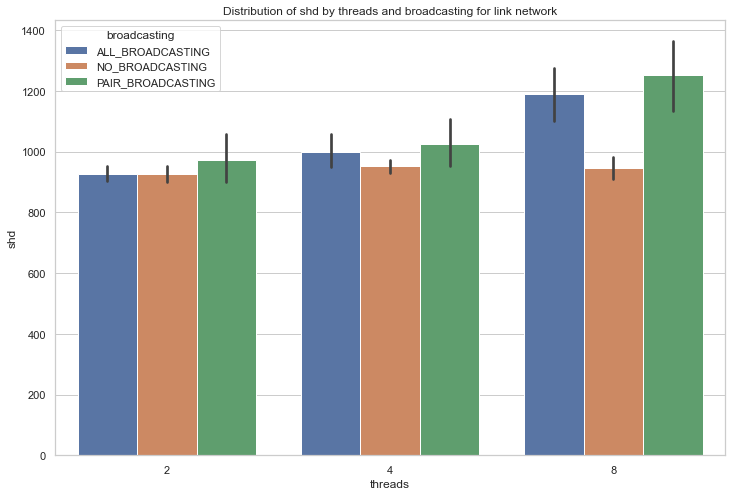

In [106]:
plot_barplot(df=df_plot,network="link",x="threads", y="shd",hue="broadcasting")

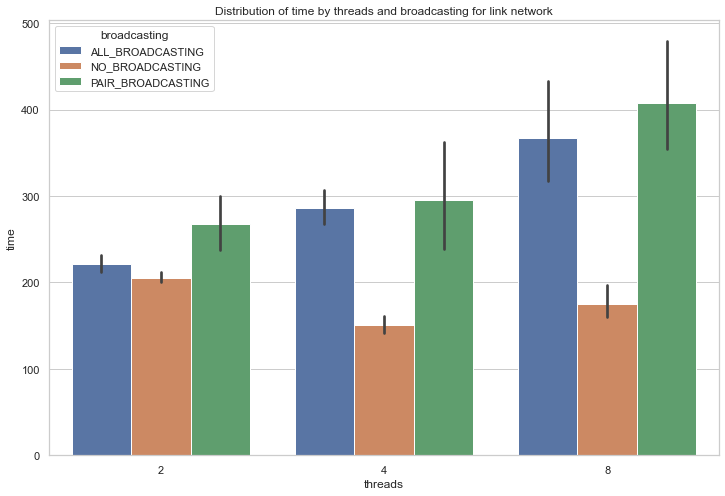

In [107]:
plot_barplot(df=df_plot,network="link",x="threads", y="time",hue="broadcasting")

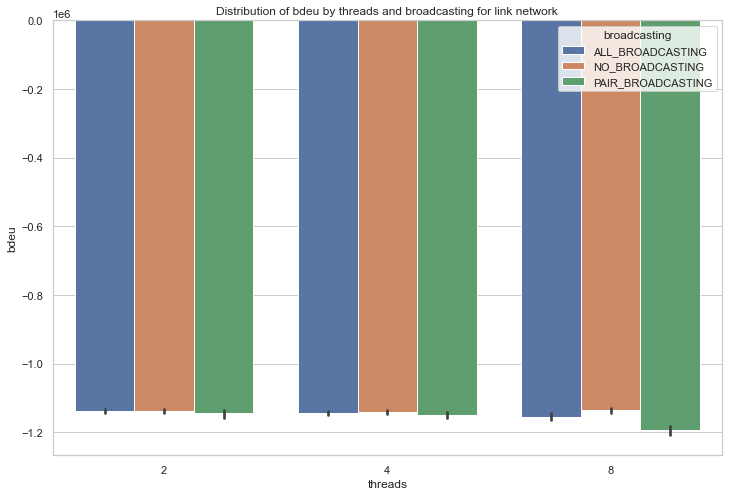

In [108]:
plot_barplot(df=df_plot,network="link",x="threads", y="bdeu",hue="broadcasting")

El análisis de los resultados concluye que el broadcasting no mejora los resultados del algoritmo CGES. Por lo tanto, no se recomienda su uso.

# Tests Estadísticos

In [73]:
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Supongamos que df tiene las columnas 'config', 'Metrica1', 'Metrica2', ...
# donde 'config' es la variable categórica que representa cada configuración.

def compare_configurations(df):
    metrics = ['bdeu', 'shd', 'time']

    df["config"] = "cges-" + df['threads'].astype(str) + '-' + df['broadcasting']


    for metric in metrics:
        anova_result = f_oneway(*[df[df['config'] == config][metric] for config in df['config'].unique()])
        print(f"ANOVA para {metric}:")
        print(anova_result)
        print()

    for metric in metrics:
        tukey_result = pairwise_tukeyhsd(df[metric], df['config'])
        print(f"Prueba de Tukey para {metric}:")
        print(tukey_result)
        print()

# compare_configurations(df)

In [74]:
compare_configurations(df)

ANOVA para bdeu:
F_onewayResult(statistic=0.06039827714016573, pvalue=0.9999935877911436)

ANOVA para shd:
F_onewayResult(statistic=0.7813521215185947, pvalue=0.6588958218245817)

ANOVA para time:
F_onewayResult(statistic=4.845475260077701, pvalue=4.249535268883236e-07)

Prueba de Tukey para bdeu:
                         Multiple Comparison of Means - Tukey HSD, FWER=0.05                          
         group1                   group2            meandiff   p-adj     lower        upper     reject
------------------------------------------------------------------------------------------------------
 cges-1-ALL_BROADCASTING   cges-1-NO_BROADCASTING          0.0   1.0 -2234362.7465 2234362.7465  False
 cges-1-ALL_BROADCASTING cges-1-PAIR_BROADCASTING          0.0   1.0 -2234362.7465 2234362.7465  False
 cges-1-ALL_BROADCASTING  cges-2-ALL_BROADCASTING  -104875.805   1.0 -2408004.2074 2198252.5975  False
 cges-1-ALL_BROADCASTING   cges-2-NO_BROADCASTING -104916.2041   1.0 -2408044.6066 

In [11]:
# Análisis de Convergencia
from scipy.stats import ttest_ind

# Comparación de dos configuraciones específicas (por ejemplo, ALL_BROADCASTING vs. PAIR_BROADCASTING)


config_1 = df[(df['broadcasting'] == 'ALL_BROADCASTING') & (df['threads'] == 1)]['bdeu']
config_2 = df[(df['broadcasting'] == 'PAIR_BROADCASTING') & (df['threads'] == 1)]['bdeu']

# Prueba t de muestras independientes
t_stat, p_value = ttest_ind(config_1, config_2)

# Visualizar resultados
print(f'Test t: {t_stat}, p-value: {p_value}')


Test t: -8.26301829836721e-07, p-value: 0.9999993424956186


## Exreport

In [110]:
import os
import shutil
# Crear una copia de df llamada df_exreport
df = df[df.threads != 1]
df_exreport = df.copy()

# Crear una columna con las configuraciones separadas por espacio. Los valores de las configuraciones están en las columnas threads y broadcasting
df_exreport['config'] = "cges-" + df_exreport['threads'].astype(str) + '-' + df_exreport['broadcasting']

# Eliminar las columnas threads y broadcasting
df_exreport = df_exreport.drop(['broadcasting'], axis=1)

df_exreport = df_exreport.groupby(["config", "netName"],observed=True).mean().reset_index()

# Redondear a 4
df_exreport = df_exreport.round(4)

# Write to csv ./exreport/exreport.csv
df_exreport.to_csv('./exreport/exreport.csv', index=False)

# Delete folder exreport_output and its content if exists
if os.path.exists('./exreport/exreport_output'):
    shutil.rmtree('./exreport/exreport_output')

# Execute exreport.r
os.system('Rscript ./exreport/exreport.r')


0

In [15]:
def generate_score_table(score_col):
    # Obtener las columnas de parámetros
    param_columns = ["algName", "netName", "clusteringName", "threads", "convergence", "broadcasting"]

    # Obtener las columnas del score
    columns = [col for col in df.columns if col.startswith(score_col)]

    # Obtener las columnas a eliminar
    columns_to_drop = [col for col in df.columns if col not in param_columns and col not in columns]

    # Eliminar las columnas
    df_unstack = df.drop(columns_to_drop, axis=1)

    # Añadir columna config
    df_unstack['config'] = "cges-" + df_unstack['threads'].astype(str) + '-' + df_unstack['broadcasting']

    # Eliminar las columnas threads y broadcasting
    df_unstack = df_unstack.drop(["threads", "broadcasting"], axis=1)

    table = df_unstack.groupby(["netName", "config"], observed=True).mean().unstack(0)
    table = table.transpose()

    # Changue index to network
    table.index = table.index.droplevel(0)

    # Ordering table
    table = table.reindex(['munin','pigs','link','andes'])

    # Capitalize the first letter of the network
    table.index = table.index.str.capitalize()

    return table

In [16]:
generate_score_table("shd")

config,cges-1-ALL_BROADCASTING,cges-1-NO_BROADCASTING,cges-1-PAIR_BROADCASTING,cges-2-ALL_BROADCASTING,cges-2-NO_BROADCASTING,cges-2-PAIR_BROADCASTING,cges-4-ALL_BROADCASTING,cges-4-NO_BROADCASTING,cges-4-PAIR_BROADCASTING,cges-8-ALL_BROADCASTING,cges-8-NO_BROADCASTING,cges-8-PAIR_BROADCASTING
netName,,,,,,,,,,,,
Munin,1461.545455,1461.090909,1461.454545,1501.750000,1511.333333,1541.333333,NaN,1569.000000,1649.571429,NaN,NaN,1559.000000
Pigs,0.000000,0.000000,0.000000,1.500000,1.833333,8.333333,12.916667,3.666667,6.333333,22.454545,5.916667,8.750000
Link,930.750000,930.750000,930.750000,909.666667,909.666667,963.750000,1055.416667,967.416667,1024.888889,1142.083333,943.250000,1227.555556
Andes,140.916667,140.916667,140.916667,156.500000,150.250000,205.500000,199.666667,167.166667,246.500000,224.583333,168.000000,251.583333
